# Setup

In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import os

import numpy as np

from yass.neuralnet import NeuralNetDetector
from yass.config import Config

from neural_noise.explorer import (SpikeTrainExplorer,
                                   RecordingExplorer)
from neural_noise import config


import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)

In [3]:
logging.basicConfig(level=logging.ERROR)

# Loading configuration files and YASS output

In [18]:
# load configuration files
cfg_yass = Config.from_yaml('../yass_config/local_100k.yaml')
cfg = config.load('../config.yaml')

In [22]:
# load data generated from yass
files = ['score', 'clear_index', 'spike_times', 'spike_train', 'spike_left', 'templates']

(score, clear_index,
 spike_times, spike_train,
 spike_left, templates) = [np.load(os.path.join(cfg['root'], 'yass/{}.npy'.format(f))) for f in  files]

In [23]:
score.shape, clear_index.shape, spike_times.shape, spike_left.shape,templates.shape

((7,), (7,), (7,), (7,), (7, 31, 5))

# Loading raw recordings, geometry file and projection matrix

In [26]:
# load standarized recordings (these are raw recordings + filter + standarization)
path_to_recordings = os.path.join(cfg_yass.root, 'tmp/standarized.bin')
# load gemetry file (position for every electro)
path_to_geometry = os.path.join(cfg_yass.root, cfg_yass.geomFile)

In [28]:
# load projection matrix (to reduce dimensionality)
proj = NeuralNetDetector(cfg_yass).load_w_ae()

# Initializing explorers

In [30]:
# initialize explorers, these objects implement functions for plotting
# the output from YASS
explorer_rec = RecordingExplorer(path_to_recordings,
                                 path_to_geometry,
                                 dtype='float64',
                                 window_size=cfg_yass.spikeSize,
                                 n_channels=cfg_yass.nChan,
                                 neighbor_radius=cfg_yass.spatialRadius)

explorer_train = SpikeTrainExplorer(templates,
                                    spike_train,
                                    explorer_rec,
                                    proj)

/Users/edu/dev/grossman/neural-noise/src/neural_noise/explorer.py:292: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if channels == 'all':


ValueError: not enough values to unpack (expected 3, got 2)

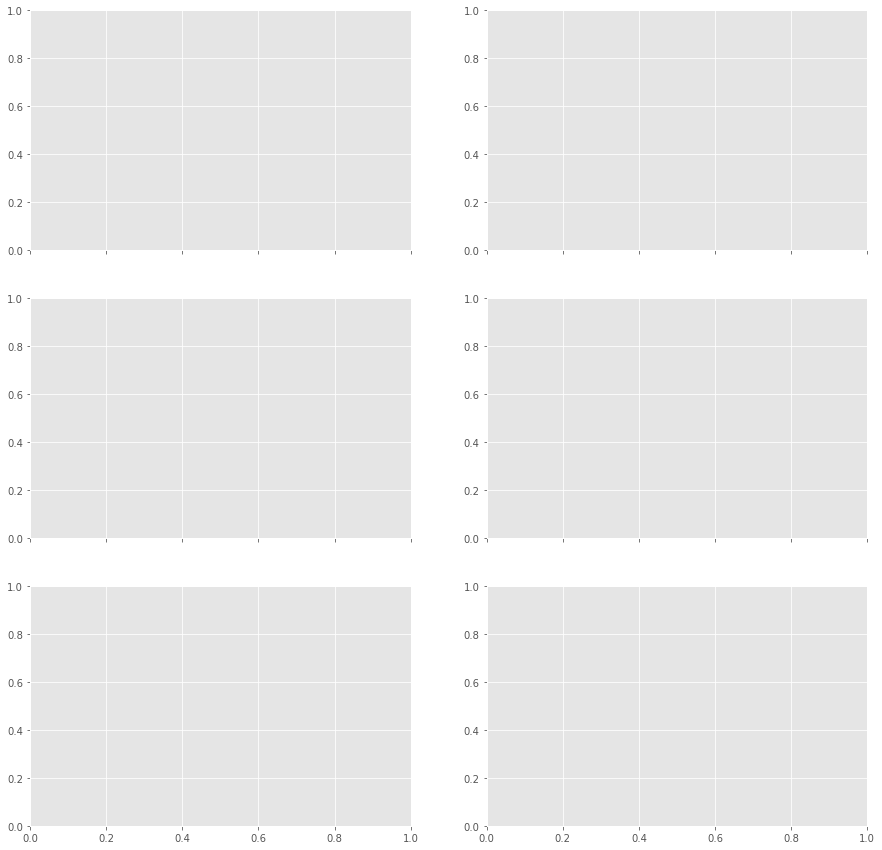

In [38]:
explorer_train.visualize_all_clusters(k=2)